In [471]:
import pennylane as qml
from pennylane import numpy as np

# 양자 장치 설정
dev = qml.device('default.mixed', wires=2)


@qml.qnode(dev)
def random_circuit(params):
    """임의의 게이트를 포함하는 기본 회로"""

    for i in range(10):
        qml.RX(params[i*3+0], wires=0)
        qml.RY(params[i*3+1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RZ(params[i*3+2], wires=0)
    return qml.expval(qml.PauliZ(0))


In [472]:
import pennylane as qml
from pennylane import numpy as np



def extra_polation(circ,theta,noise_factor=[0,1,2,3],p1=0.01,p2=0.02):
    
    real_vaule = circ(theta)
    dev = circ.device
    ops = circ.qtape.operations
    ops_inv = ops[::-1]


    meas = circ.qtape.measurements[0]
    def noise_circ():
        for op in ops:
            eval(f'qml.{op}')
            if len(op.wires)>1:
                for wire in op.wires:
                    qml.DepolarizingChannel(p1, wires=wire)
                    qml.BitFlip(p2, wires=wire)
            else:
                qml.DepolarizingChannel(p1, wires=op.wires) 
                qml.BitFlip(p2, wires=op.wires)
    def noise_circ_inv():
        for op in ops_inv:
            eval(f'qml.adjoint(qml.{op})')
            if len(op.wires)>1:
                for wire in op.wires:
                    qml.DepolarizingChannel(p1, wires=wire)
                    qml.BitFlip(p2, wires=wire)
            else:
                qml.DepolarizingChannel(p1, wires=op.wires) 
                qml.BitFlip(p2, wires=op.wires)
    
    @qml.qnode(dev)
    def extra_polation(factor):
        Z = qml.PauliZ
        Y = qml.PauliY
        X = qml.PauliX
        for i in range(factor):
            noise_circ()
            noise_circ_inv()
        noise_circ()
        return eval(f"qml.{meas}")
    




    res = []
    for factor in noise_factor:
        res.append(extra_polation(factor))
    return res,real_vaule

In [473]:
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
# 데이터셋 생성 클래스
class QuantumData(Dataset):
    def __init__(self, size=500):
        self.data = []
        self.labels = []
        for _ in tqdm(range(size)):
            theta = [np.random.uniform(0, 2 * np.pi) for i in range(30)]
            noise_factor,result = extra_polation(random_circuit,theta,noise_factor=[0,1,2,3],p1=0.01,p2=0.02)
            self.data.append(np.array(noise_factor))
            self.labels.append(result)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# 데이터셋 및 데이터 로더 생성
dataset = QuantumData()
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [07:23<00:00,  1.13it/s]


In [561]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(4, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)
        self.relu = nn.GELU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return torch.squeeze(self.fc3(x))

model_MLP = RegressionModel()
criterion = nn.MSELoss()
optimizer_MLP = torch.optim.Adam(model_MLP.parameters(), lr=0.01)

from kan import KAN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.KAN = KAN([4,1,1],grid=5)
    def forward(self, x):
        output = self.KAN(x)
        #output = nn.Sigmoid()(output)
        output = torch.squeeze(output)
        return output


model = Model()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [562]:
from functions.training import Early_stop_train_KAN

train_seq = Early_stop_train_KAN(model,optimizer,criterion)

train_seq.train_model(train_loader,val_loader)


Test set: Average loss: 0.3629, Accuracy: 0.0/100 (0%)
Epoch 1 Loss 0.156145 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.3326, Accuracy: 0.0/100 (0%)
Epoch 2 Loss 0.143109 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.2539, Accuracy: 0.0/100 (0%)
Epoch 3 Loss 0.102056 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.1701, Accuracy: 0.0/100 (0%)
Epoch 4 Loss 0.063542 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.0898, Accuracy: 0.0/100 (0%)
Epoch 5 Loss 0.028758 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.0330, Accuracy: 0.0/100 (0%)
Epoch 6 Loss 0.011947 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.0303, Accuracy: 0.0/100 (0%)
Epoch 7 Loss 0.014591 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.0357, Accuracy: 0.0/100 (0%)
Epoch 8 Loss 0.013332 acc : 0.000000 reg : 0.000000 stop count : 1
Test set: Average loss:

In [567]:
model.KAN.auto_symbolic()

fixing (0,0,0) with sin, r2=0.9999704360961914
fixing (0,1,0) with 1/x^4, r2=1.0000004768371582
fixing (0,2,0) with exp, r2=0.9999726414680481
fixing (0,3,0) with 1/x, r2=0.9396162629127502
fixing (1,0,0) with abs, r2=0.9999914169311523


In [568]:
model.KAN.symbolic_formula()[0][0]

0.76 - 0.29*Abs(1.25*exp(10.0*x_3) + 4.99*sin(3.35*x_1 + 9.39) - 14.98 + 16.24/(1 - 0.16*x_2)**4)

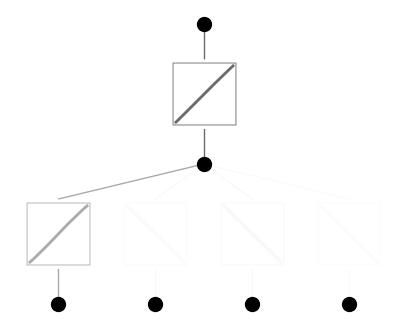

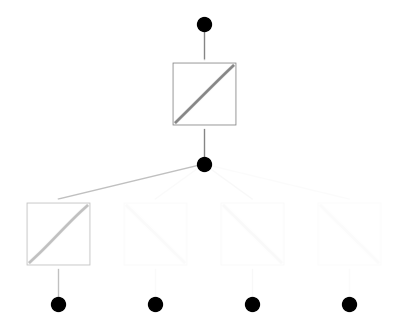

In [563]:
model.KAN.plot()
model.KAN = model.KAN.prune(threshold=0.07)
model(inputs_val)
model.KAN.plot()

AttributeError: 'KAN' object has no attribute 'mask'

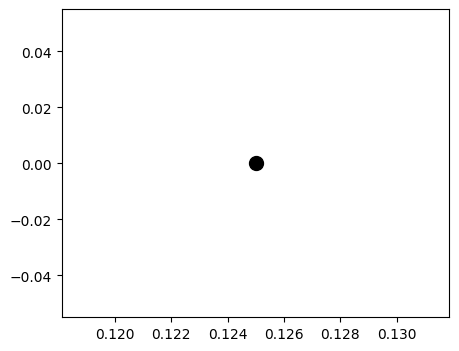

In [565]:
model.KAN.plot(mask=True)

In [520]:
from functions.training import Early_stop_train

train_seq = Early_stop_train(model_MLP,optimizer_MLP,criterion)

train_seq.train_model(train_loader,val_loader)


Test set: Average loss: 0.3939, Accuracy: 0.0/100 (0%)
Epoch 1 Loss 0.178795 acc : 0.000000 stop count : 0
Test set: Average loss: 0.3285, Accuracy: 0.0/100 (0%)
Epoch 2 Loss 0.141259 acc : 0.000000 stop count : 0
Test set: Average loss: 0.1985, Accuracy: 0.0/100 (0%)
Epoch 3 Loss 0.072215 acc : 0.000000 stop count : 0
Test set: Average loss: 0.0511, Accuracy: 0.0/100 (0%)
Epoch 4 Loss 0.015727 acc : 0.000000 stop count : 0
Test set: Average loss: 0.0521, Accuracy: 0.0/100 (0%)
Epoch 5 Loss 0.023369 acc : 0.000000 stop count : 1
Test set: Average loss: 0.0267, Accuracy: 0.0/100 (0%)
Epoch 6 Loss 0.015201 acc : 0.000000 stop count : 0
Test set: Average loss: 0.0414, Accuracy: 0.0/100 (0%)
Epoch 7 Loss 0.016004 acc : 0.000000 stop count : 1
Test set: Average loss: 0.0389, Accuracy: 0.0/100 (0%)
Epoch 8 Loss 0.012366 acc : 0.000000 stop count : 2
Test set: Average loss: 0.0309, Accuracy: 0.0/100 (0%)
Epoch 9 Loss 0.013695 acc : 0.000000 stop count : 3
Test set: Average loss: 0.0374, Accu

In [502]:
from torch.utils.data import random_split, DataLoader
# 데이터셋 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
from functions.training import Early_stop_train_KAN

train_seq = Early_stop_train_KAN(model,optimizer,criterion)

train_seq.train_model(train_loader,val_loader)

"""
# 모델, 손실 함수, 옵티마이저 초기화
model = RegressionModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 훈련 및 검증 루프
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            outputs = model(inputs_val)
            loss = criterion(outputs, labels_val)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")"""


Test set: Average loss: 0.9624, Accuracy: 0.0/100 (0%)
Epoch 1 Loss 0.354825 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.6017, Accuracy: 0.0/100 (0%)
Epoch 2 Loss 0.229636 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.4565, Accuracy: 0.0/100 (0%)
Epoch 3 Loss 0.200533 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.4135, Accuracy: 0.0/100 (0%)
Epoch 4 Loss 0.187401 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.4004, Accuracy: 0.0/100 (0%)
Epoch 5 Loss 0.188833 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.3952, Accuracy: 0.0/100 (0%)
Epoch 6 Loss 0.182674 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.3932, Accuracy: 0.0/100 (0%)
Epoch 7 Loss 0.188731 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.3919, Accuracy: 0.0/100 (0%)
Epoch 8 Loss 0.190261 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss:

'\n# 모델, 손실 함수, 옵티마이저 초기화\nmodel = RegressionModel()\ncriterion = nn.MSELoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001)\n\n# 훈련 및 검증 루프\nnum_epochs = 5000\nfor epoch in range(num_epochs):\n    model.train()\n    train_loss = 0\n    for inputs, labels in train_loader:\n        optimizer.zero_grad()\n        outputs = model(inputs)\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n        train_loss += loss.item()\n    \n    train_loss /= len(train_loader)\n    \n    model.eval()\n    val_loss = 0\n    with torch.no_grad():\n        for inputs_val, labels_val in val_loader:\n            outputs = model(inputs_val)\n            loss = criterion(outputs, labels_val)\n            val_loss += loss.item()\n    \n    val_loss /= len(val_loader)\n    \n    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")'

In [529]:
res_MLP = []
res_RAW = []
res_line_list = []

for i in range(36):
    
    print(f'MLP ZEN dist : {abs(model(inputs_val[i,None]).item()-labels_val[i])}')
    res_MLP.append(abs(model(inputs_val[i,None]).item()-labels_val[i]))
    print(f'RAW dist : {abs(inputs_val[i][0]-labels_val[i])}')
    res_RAW.append(abs(inputs_val[i][0]-labels_val[i]))
    res_line = np.polyfit([1,3,5,7], inputs_val[i], 1)[1]
    print(f'Line dist : {abs(res_line.item()-labels_val[i])}')
    res_line_list.append(abs(res_line.item()-labels_val[i]))

c:\Users\pad33\anaconda3\envs\KAN\lib\site-packages\kan\KAN.py:327: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


MLP ZEN dist : 0.14955700933933258
RAW dist : 0.1532641053199768
Line dist : 0.16159355640411377
MLP ZEN dist : 0.10771334171295166
RAW dist : 0.18776066601276398
Line dist : 0.1903919279575348
MLP ZEN dist : 0.052278101444244385
RAW dist : 0.3093665838241577
Line dist : 0.32062798738479614
MLP ZEN dist : 0.05065947771072388
RAW dist : 0.19946980476379395
Line dist : 0.2069738656282425
MLP ZEN dist : 0.05468130111694336
RAW dist : 0.36115068197250366
Line dist : 0.37305277585983276
MLP ZEN dist : 0.12824797630310059
RAW dist : 0.02719835191965103
Line dist : 0.03183937072753906
MLP ZEN dist : 0.03492026776075363
RAW dist : 0.049839843064546585
Line dist : 0.05169253051280975
MLP ZEN dist : 0.11827421188354492
RAW dist : 0.41442620754241943
Line dist : 0.43196535110473633
MLP ZEN dist : 0.17221030592918396
RAW dist : 0.3034900426864624
Line dist : 0.3105599880218506
MLP ZEN dist : 0.11819145083427429
RAW dist : 0.4393290579319
Line dist : 0.45247897505760193
MLP ZEN dist : 0.03230744600

In [530]:
np.mean(res_MLP),np.mean(res_RAW),np.mean(res_line_list)

(0.08110244, 0.28690073, 0.29625443)